Examples of CountCorrect Output to be included in the paper

In [1]:
import sys,os
path = '/nfs/team283/aa16/InSituCellTools/'
os.chdir(path)
sys.path.append(path)

Load the required modules and configure theano settings:

In [2]:
import pickle
import anndata
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import diffxpy.api as de
from IPython.display import Image
import statsmodels.stats.multitest as multi
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True' + ',dnn.enabled=False'
from isctools.ProbeCounts__GeneralModel_V2_SmoothedOverdispersion import ProbeCounts_GeneralModel_V2
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:62:00.0)


Load data from our NanostringWTA run:

In [3]:
adata_wta = pickle.load(open(path + "data/nanostringWTA_fetailBrain_AnnData.p", "rb" ))

In [4]:
adata_wta = adata_wta[adata_wta.obs['GoodQuality'],:]

There is currently no good way to account for batch effects in our model. Hence, we recommend fitting seperate models to seperate batches. In this analysis we only consider AOIs on one section:

In [5]:
adata_wta = adata_wta[[adata_wta.obs['slide'][i] in ('00MU') for i in range(len(adata_wta.obs['slide']))]]
np.shape(adata_wta)

(74, 18416)

The model needs seperate gene probes and negative probes in two numpy arrays. We initialize them here:

In [6]:
counts_geneProbes = np.asarray(adata_wta[:,np.array(adata_wta.var != 'NegProbe-WTX').squeeze()].X)
counts_negativeProbes = np.asarray(adata_wta[:,np.array(adata_wta.var == 'NegProbe-WTX').squeeze()].X)
counts_nuclei = np.asarray(adata_wta.obs['nuclei']).reshape(len(adata_wta.obs['nuclei']),1).squeeze()

Now we define the model:

In [7]:
mod1 = ProbeCounts_GeneralModel_V2(
        X_data = counts_geneProbes,
        Y_data = counts_negativeProbes,
        nuclei = counts_nuclei,
        var_names = adata_wta.var_names[adata_wta.var_names != 'NegProbe-WTX'],
        n_factors = 15,
        v_mu_e_g = 0.25,
        v_mu_b_n_hyper = 0.25,
        mu_l_v_g = 0.1)

And fit the model to our data using automatic differentiation variational inference (advi):

Average Loss = 5.3922e+06: 100%|██████████| 300000/300000 [1:04:52<00:00, 77.08it/s]
Finished [100%]: Average Loss = 5.3922e+06


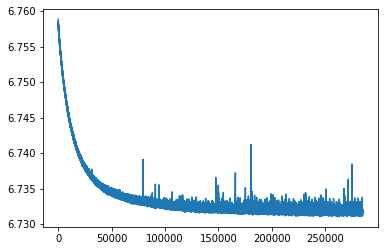

In [8]:
total_iterations = 3*10**5
mod1.fit_advi_iterative(n_iter = total_iterations, learning_rate = 0.001, n=1, method='advi')

The optimization history above suggests that the optimization has converged. To confirm this we can also inspect the last 10000 iterations:

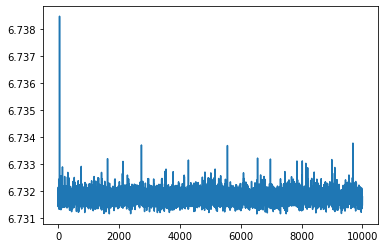

In [9]:
mod1.plot_history(total_iterations - 10000)

We see that the loss is constant in the last 10000 iterations. Overall, this suggests the optimization has really converged.

Now that we fit the model to our data we can get a new count matrix that is corrected for background and sampling noise. To approximate this corrected count matrix we take 1000 samples from the posterior distribution of the model:

In [10]:
mod1.sample_posterior(node='all', n_samples=1000, save_samples=False);

And then compute "X_corrected" as A_gr in the model description above:

In [11]:
ProbeCounts_GeneralModel_V2.compute_X_corrected(mod1)

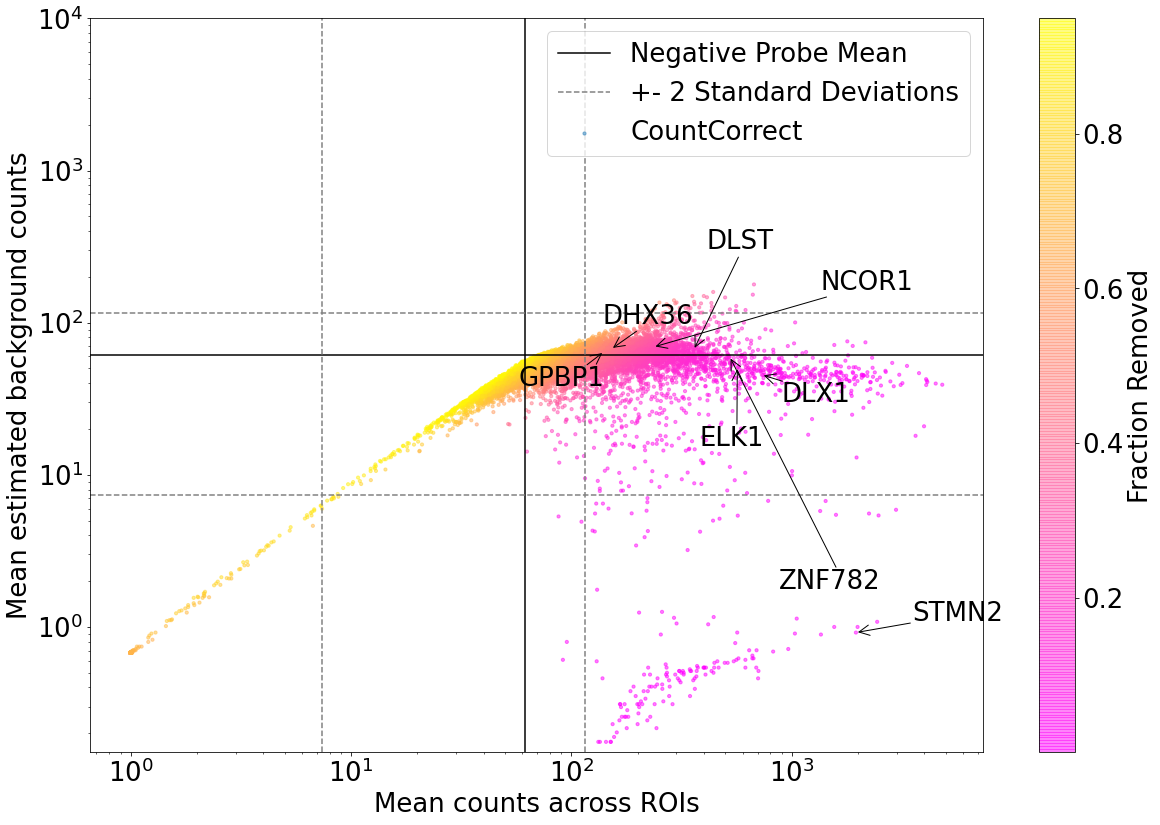

In [12]:
genesOfInterest = np.array(('DLX1', 'STMN2', 'ELK1', 'DLST', 'ZNF782', 'NCOR1', 'DHX36', 'GPBP1'))
ProbeCounts_GeneralModel_V2.plot_X_corrected_overview5(mod1, genesOfInterest, cmap = 'spring')

We can also rank genes by what percentage of counts were removed from them:

In [14]:
rankedGenes = mod1.rank_X_corrected_genes()
rankedGenes

,Gene,Total Counts,Removed Counts,Fraction Removed Counts (Mean),Fraction Removed Counts (q05),Fraction Removed Counts (q95)
HEATR3,HEATR3,2902,2755,0.949345,0.932116,0.963818
EIPR1,EIPR1,3485,3297,0.946055,0.928551,0.959254
COPS7B,COPS7B,3030,2859,0.943564,0.927063,0.956436
LYRM7,LYRM7,3045,2866,0.941215,0.925123,0.954351
C11orf71,C11orf71,2866,2692,0.939288,0.925331,0.951849
...,...,...,...,...,...,...
SLA,SLA,46179,3,0.000065,0.000000,0.000325
FABP7,FABP7,108893,5,0.000046,0.000000,0.000257
SATB2,SATB2,73965,3,0.000041,0.000000,0.000176
TUBB2A,TUBB2A,129296,4,0.000031,0.000000,0.000116


Let's gather the top 3 genes with most removed counts and put them in a list with a few well known cell type markers. Then let's look up this list of genes in the scRNAseq study by Polioudakis et al., Neuron 2019, to check how cell types in the fetal brain express those genes:

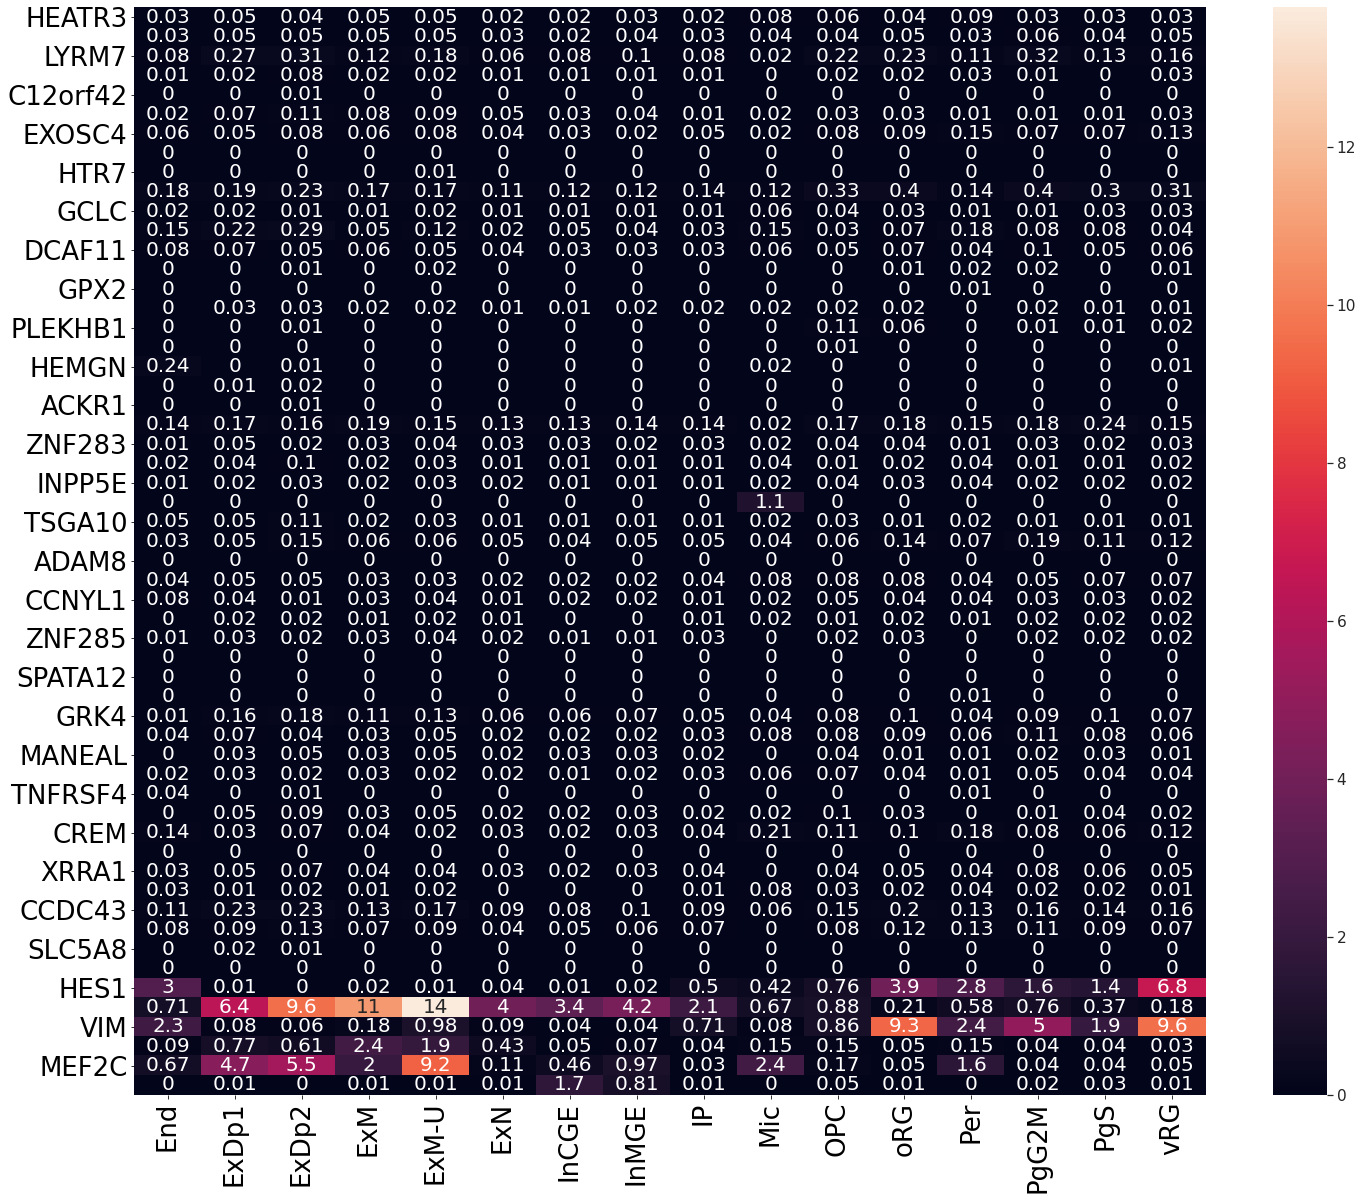

In [15]:
# Get reference scRNAseq data:
meanExpression_sc = pd.read_csv(path + "data/polioudakis2019_meanExpressionProfiles.csv", index_col=0)

# Make our gene list:
commonGenes = [rankedGenes['Gene'].iloc[i] for i in range(len(rankedGenes)) if rankedGenes['Gene'].iloc[i] in meanExpression_sc.index]
topGenes = commonGenes[0:50]
celltypeMarkers = np.array(('HES1', 'STMN2','VIM', 'SATB2', 'MEF2C', 'DLX1'))
lookup_genes = np.concatenate([topGenes, celltypeMarkers])

# Plot cell type specific expression of genes:
fig, ax = plt.subplots(figsize=(24,20))
sns.set(font_scale=1.4)
sns.heatmap(np.round(meanExpression_sc.loc[lookup_genes,:],2), annot = True,  annot_kws={"size": 20})

In [ ]:
topGenes = commonGenes[0:50]
plt.hist(np.mean(meanExpression_sc, axis = 1), density = True, color = 'blue')
plt.hist(np.mean(meanExpression_sc.loc[topGenes,:], axis = 1), density = True, color = 'green')

In [ ]:
meanExpression_sc.loc[topGenes,:].iloc[np.argsort(-np.mean(meanExpression_sc.loc[topGenes,:], axis = 1))]

In [ ]:
np.sum(np.mean(meanExpression_sc.loc[topGenes,:], axis = 1) < 0.2)

Excluding ATRX, the genes with many removed counts are not supposed to be expressed in the fetal brain at a high level at all, yet they have more total counts than some of our cell type markers, which we can see by inspecting the rankedGenes dataframe:

In [ ]:
rankedGenes.loc[[rankedGenes['Gene'].iloc[i] in lookup_genes for i in range(len(rankedGenes['Gene']))],:]

Hence the model likely correctly identified faulty probes with an excessive number of non-specific binding events.

One weakness of the current model seems to be that it never identifies 100% of the counts as measurement noise (one of the disadvantages of non-negative matrix factorization used for A_rg in the model is that values don't tend to go to 0). Hence, all genes still have at least 1 count. To determine, which genes are detected in a given ROI/AOI, we thus need to choose an arbitrary cutoff, which we choose at 50 counts for now. This roughly matches the number of detected genes we get by using the limit of detection provided by the Nanostring software, as shown in the following plot, that illustrates the number of detected genes per ROI across cortical depth:

In [ ]:
absolute_cutoff = 50
ProbeCounts_GeneralModel_V2.compute_X_detected(mod1)
print('X_detected', mod1.X_detected)

In [ ]:
x = np.asarray(adata_wta.obs['VCDepth'])
order = np.where([adata_wta.obs['Radial_position'][i] == 2 for i in range(len(adata_wta.obs['Radial_position']))])[0]
nuclei = np.asarray(adata_wta.obs['nuclei'])
LoD_cutoff = adata_wta.obs['GeoLOD2.5_01']

Finally, let's plot a comparison of our corrected and cpm normalized counts (ISC-CPM) and uncorrected standard counts-per-million (CPM) for a list of chosen genes. This list contains ATRX, plus other genes that are differentially expressed in certain fetal brain cell types (again taken from the Polioudakis et al. Neuron 2019 study), as shown in the heatmap:

In [ ]:
# example_genes = np.array(('INTU', 'DLX1', 'HOPX', 'CDH13', 'ATRX', 'STMN2', 'B4GAT1',  'ELK1'))
example_genes = np.array(('INTU', 'DLX1', 'HOPX', 'CDH13', 'ATRX', 'STMN2', 'B4GAT1', 'ELK1', 'ZNF782', ))
# Plot cell type specific expression of genes:
fig, ax = plt.subplots(figsize=(24,10))
sns.set(font_scale=1.4)
sns.heatmap(np.round(meanExpression_sc.loc[example_genes,:],2), annot = True,  annot_kws={"size": 20})

And this is their expression across cortical depth as counts per million, both corrected (ISC-CPM) and uncorrected (CPM):

In [ ]:
x = np.asarray(adata_wta.obs['VCDepth'])
order = np.where([adata_wta.obs['Radial_position'][i] == 2 for i in range(len(adata_wta.obs['Radial_position']))])[0]

In [ ]:
import imp
import isctools
from isctools import pymc3_model
imp.reload(isctools.pymc3_model)
imp.reload(isctools.ProbeCounts__GeneralModel_V1)
from isctools.ProbeCounts__GeneralModel_V1 import ProbeCounts_GeneralModel_V1
ProbeCounts_GeneralModel_V1.plot_X_corrected_exampleGenes(mod1, x, order, example_genes, saveFig = 'ExampleGenes.pdf')

Clearly, the corrected counts (ISC-CPM) make a lot of sense, since they result in high expression at cortical depths, where we would expect the cell type they mark to be located. For example, INTU is particularly highly expressed in vRGs and oRGs, which are found at lower cortical depth and CDH13 is particulary highly expressed in deep layer excitatory neurons, which are found at higher cortical depth. Finally ATRX is expressed in most cell types, but most highly in deep layer excitatory neurons, which is exactly where the expression peaks on the plot.

Furthermore we can compare downstream analysis results between using ISC-CPM and standard CPM. For example doing a standard Wilcoxon rank sum test with the diffxpy python package to find differentially expressed genes between HOPX positive and EOMES positive cell type specific AOIs:

In [ ]:
# Get our HOPXpos and EOMESpos AOIs (excluding HOPX AOIs in VZ):
order_HOPX = np.where([adata_wta.obs['AOI_type'][i] == 'HOPXpos' and adata_wta.obs['VCDepth'][i] > 0.05 for i in range(len(adata_wta.obs['Radial_position']))])[0]
order_EOMES = np.where([adata_wta.obs['AOI_type'][i] == 'EOMESpos' for i in range(len(adata_wta.obs['Radial_position']))])[0]
order = np.concatenate([order_HOPX, order_EOMES])

# Get cpm for both corrected (isc_cpm) and uncorrected data (cpm):
total_counts = np.sum(mod1.X_data, axis = 1)
cpm = mod1.X_data/total_counts.reshape(np.shape(mod1.X_data)[0],1)*10**6
isc_cpm = mod1.X_corrected_mean/total_counts.reshape(np.shape(mod1.X_data)[0],1)*10**6

# Put data into two AnnData objects:
adata_cpm = adata = sc.AnnData(X=cpm[order],
                               obs=pd.DataFrame(data = np.concatenate([np.repeat('HOPXpos', len(order_HOPX)),
                                                                      np.repeat('EOMESpos', len(order_EOMES))]),
                                                columns = ['Cell Type']))

adata_isc_cpm = adata = sc.AnnData(X=isc_cpm[order],
                               obs=pd.DataFrame(data = np.concatenate([np.repeat('HOPXpos', len(order_HOPX)),
                                                                      np.repeat('EOMESpos', len(order_EOMES))]),
                                                columns = ['Cell Type']))

# Perform differential expression with diffxpy for both cases:

test_rank_cpm = de.test.rank_test(
    data=adata_cpm,
    grouping="Cell Type",
    gene_names = mod1.var_names,
    ).summary()

test_rank_isc_cpm = de.test.rank_test(
    data=adata_isc_cpm,
    grouping="Cell Type",
    gene_names = mod1.var_names,
    ).summary()


# Add FDR:

test_rank_cpm['FDR'] = multi.multipletests(test_rank_cpm['pval'], method = 'fdr_bh')[1]
test_rank_isc_cpm['FDR'] = multi.multipletests(test_rank_isc_cpm['pval'], method = 'fdr_bh')[1]


In [ ]:
len(order_HOPX)
#len(order_EOMES)

Without correction we have 195 genes with an (absolute) log2FC > 1 and q-value < 0.05, but with correction we get 1227:

In [ ]:
threshold = 1

In [ ]:
cpm_genes1 = np.asarray(test_rank_cpm['gene'].loc[[test_rank_cpm['FDR'][i] < 0.05 and abs(test_rank_cpm['log2fc'][i]) > threshold for i in range(len(test_rank_cpm['qval']))]])
isc_cpm_genes1 = np.asarray(test_rank_isc_cpm['gene'].loc[[test_rank_isc_cpm['FDR'][i] < 0.05 and abs(test_rank_isc_cpm['log2fc'][i]) > threshold for i in range(len(test_rank_cpm['qval']))]])

print(len(cpm_genes1))
print(len(isc_cpm_genes1))

If we do not have a log2FC cutoff the difference becomes even larger:

In [ ]:
cpm_genes2 = np.asarray(test_rank_cpm['gene'].loc[[test_rank_cpm['FDR'][i] < 0.05 for i in range(len(test_rank_cpm['qval']))]])
isc_cpm_genes2 = np.asarray(test_rank_isc_cpm['gene'].loc[[test_rank_isc_cpm['FDR'][i] < 0.05 for i in range(len(test_rank_cpm['qval']))]])

print(len(cpm_genes2))
print(len(isc_cpm_genes2))

But are these additional genes biologically sensible? To check for this we can compare them to differentially expressed genes between IPs and oRGs in our reference scRNAseq study (Polioudakis et al., Neuron 2019). We load Wilcoxon rank sum test results for cpm normalized data from this study here:

In [ ]:
sc_de_results = pickle.load(open("/nfs/team283/aa16/KR_NAS/data/oRG_IP_scRNAseq_DE_cpm_results.p", "rb"))

In [ ]:
group1_reference = np.asarray(sc_de_results['gene'].loc[[sc_de_results['qval'][i] < 0.05 and sc_de_results['log2fc'][i] > threshold for i in range(len(sc_de_results['log2fc']))]])
group2_reference = np.asarray(sc_de_results['gene'].loc[[sc_de_results['qval'][i] < 0.05 and sc_de_results['log2fc'][i] < -threshold for i in range(len(sc_de_results['log2fc']))]])
negatives_reference = np.asarray(sc_de_results['gene'].loc[[sc_de_results['gene'][i] not in group1_reference and sc_de_results['gene'][i] not in group2_reference for i in range(len(sc_de_results['gene']))]])


In [ ]:
len(group1_reference) + len(group2_reference)

Next we split genes into three groups, depending on whether they are differentially expressed with a log2FC > 1 for oRG, IP or not differentially expressed.

In [ ]:
group1_cpm = np.asarray(test_rank_cpm['gene'].loc[[test_rank_cpm['qval'][i] < 0.05 and test_rank_cpm['log2fc'][i] > threshold for i in range(len(test_rank_cpm['qval']))]])
group2_cpm = np.asarray(test_rank_cpm['gene'].loc[[test_rank_cpm['qval'][i] < 0.05 and test_rank_cpm['log2fc'][i] < -threshold for i in range(len(test_rank_cpm['qval']))]])
negatives_cpm = np.asarray(test_rank_cpm['gene'].loc[[test_rank_cpm['gene'][i] not in group1_cpm and test_rank_cpm['gene'][i] not in group2_cpm for i in range(len(test_rank_cpm['gene']))]])
                                    
group1_isc_cpm = np.asarray(test_rank_isc_cpm['gene'].loc[[test_rank_isc_cpm['qval'][i] < 0.05 and test_rank_isc_cpm['log2fc'][i] > threshold for i in range(len(test_rank_isc_cpm['qval']))]])
group2_isc_cpm = np.asarray(test_rank_isc_cpm['gene'].loc[[test_rank_isc_cpm['qval'][i] < 0.05 and test_rank_isc_cpm['log2fc'][i] < -threshold for i in range(len(test_rank_isc_cpm['qval']))]])
negatives_isc_cpm = np.asarray(test_rank_isc_cpm['gene'].loc[[test_rank_isc_cpm['gene'][i] not in group1_cpm and test_rank_isc_cpm['gene'][i] not in group2_cpm for i in range(len(test_rank_isc_cpm['gene']))]])

group1_reference = np.asarray(sc_de_results['gene'].loc[[sc_de_results['qval'][i] < 0.05 and sc_de_results['log2fc'][i] > threshold for i in range(len(sc_de_results['log2fc']))]])
group2_reference = np.asarray(sc_de_results['gene'].loc[[sc_de_results['qval'][i] < 0.05 and sc_de_results['log2fc'][i] < -threshold for i in range(len(sc_de_results['log2fc']))]])
negatives_reference = np.asarray(sc_de_results['gene'].loc[[sc_de_results['gene'][i] not in group1_reference and sc_de_results['gene'][i] not in group2_reference for i in range(len(sc_de_results['gene']))]])


Then we use a simple function to calculate precision and recall and f-score (the geometric mean of the two) based on these groups:

In [ ]:
def evaluatePerformance(group1, group2, negatives, group1_reference, group2_reference, negatives_reference):
    
    # Reduce to common genes:
    test_genes = np.concatenate([group1, group2, negatives])
    reference_genes = np.concatenate([group1_reference, group2_reference, negatives_reference])
    common_genes = reference_genes[[reference_genes[i] in test_genes for i in range(len(reference_genes))]]
    
    group1 = group1[[group1[i] in common_genes for i in range(len(group1))]]
    group2 = group2[[group2[i] in common_genes for i in range(len(group2))]]
    negatives = negatives[[negatives[i] in common_genes for i in range(len(negatives))]]
    
    group1_reference = group1_reference[[group1_reference[i] in common_genes for i in range(len(group1_reference))]]
    group2_reference = group2_reference[[group2_reference[i] in common_genes for i in range(len(group2_reference))]]
    negatives_reference = negatives_reference[[negatives_reference[i] in common_genes for i in range(len(negatives_reference))]]
    
    # Calculate recall, precision and f-score:
    recall = (sum([group1[i] in group1_reference for i in range(len(group1))]) +
    sum([group2[i] in group2_reference for i in range(len(group2))]))/(len(group1_reference) + len(group2_reference)) 
                                                                       
    precision = (sum([group1[i] in group1_reference for i in range(len(group1))])+
                 sum([group2[i] in group2_reference for i in range(len(group2))]))/(len(group1) + len(group2))   
                                                                       
    fscore = 2*(precision*recall)/(precision+recall)
    
    return np.array((fscore, precision, recall))

In [ ]:
evaluatePerformance(group1_cpm, group2_cpm, negatives_cpm, group1_reference, group2_reference, negatives_reference)

In [ ]:
evaluatePerformance(group1_isc_cpm, group2_isc_cpm, negatives_isc_cpm, group1_reference, group2_reference, negatives_reference)

Hence, using the corrected counts increase recall from 0.05 to 0.2 and increases the f-score from 0.1 to 0.29 and thus overall improves differential expression performance.

Finally, using the X_corrected_mean matrix in the downstream analysis actually disregards a lot of uncertainty that remains about the magnitude of the measurement noise. To circumvent this problem, we also have a differential expression method that directly works with the full model posterior distribution and computes the average log2FC and associated uncertainty across a set of chosen ROIs/AOIs:

In [ ]:
import imp
import isctools
from isctools import pymc3_model
imp.reload(isctools.pymc3_model)
imp.reload(isctools.ProbeCounts__GeneralModel_V1)
from isctools.ProbeCounts__GeneralModel_V1 import ProbeCounts_GeneralModel_V1

In [ ]:
ProbeCounts_GeneralModel_V1.compute_logFC(mod1, groupA = order_HOPX, groupB = order_EOMES)

In [ ]:
ProbeCounts_GeneralModel_V1.plot_X_corrected_exampleGenes(mod1

In [ ]:
mod1.compute_FDR(logFC_threshold = threshold)

In [ ]:
mod1.logFC

Surprisingly, with an f-score of 0.27 this approach does not perform quite as well as applying a Wilcoxon rank-sum test on the X_corrected_mean matrix (which had an f-score of 0.29):

In [ ]:
group1_isc_full = np.asarray(mod1.logFC.index[[mod1.logFC['FDR'].iloc[i] < 0.05 and mod1.logFC['mean'][i] > threshold for i in range(len(mod1.logFC['mean']))]])
group2_isc_full = np.asarray(mod1.logFC.index[[mod1.logFC['FDR'].iloc[i] < 0.05 and mod1.logFC['mean'][i] < -threshold for i in range(len(mod1.logFC['mean']))]])
negatives_isc_full = np.asarray(mod1.logFC.index[[mod1.logFC.index[i] not in group1_isc_full and mod1.logFC.index[i] not in group2_isc_full for i in range(len(mod1.logFC.index))]])

In [ ]:
evaluatePerformance(group1_isc_full, group2_isc_full, negatives_isc_full, group1_reference, group2_reference, negatives_reference)

However, the difference is small. In addition, our benchmark is far from perfect for multiple reasons. Firstly, there may be differences between scRNAseq and in-situ transcriptomic data, as well as between different brain regions. Furthermore, we used the same test (Wilcoxon rank sum) to establish our benchmark, hence this can bias the results towards using the Wilcoxon rank sum test alone. Finally, there may be differences in the data resulting from imperfect image segmentation that selected parts of other cell types in addition to HOPX positive and EOMES positives cells. So overall, we recommend using both approaches for differential expression for now.

In [ ]:
import imp
import isctools
from isctools import pymc3_model
imp.reload(isctools.pymc3_model)
imp.reload(isctools.ProbeCounts__GeneralModel_V1)
from isctools.ProbeCounts__GeneralModel_V1 import ProbeCounts_GeneralModel_V1

For illustration purposes let's plot the results of the wilcoxon rank sum test with and without correction as well as the results of the generative model in a volcano plot:

In [ ]:
from adjustText import adjust_text

def plot_volcano_with_reference(self,  group1_reference, group2_reference,
                                genesOfInterest = None, n_max_genes = 1, alpha = 0.25, FDR_cutoff = 0.05,
                                height = 10, width = 10, posterios_samples = 1000, saveFig = None):
    r""" Make a volcano plot of the differential expression analysis.
    :genesOfInterest: numpy array of genes to annotate in the plot
    :n_max_genes: number of genes to automatically annotate at the extreme ends of the plot,
    i.e. the most differentially expressed genes
    :alpha: transparency of dots 
    :FDR_cutoff: what false discovery rate to use
    :height: height of figure
    :width: width of figure
    """
    
    subset2 = [self.logFC.index[i] in group1_reference for i in range(len(self.logFC.index))]
    subset3 = [self.logFC.index[i] in group2_reference for i in range(len(self.logFC.index))]
    
    # Set figure parameters:
    SMALL_SIZE = 20
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 20
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title    
    
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 1
    plt.rcParams['grid.color'] = "#cccccc"
    
    fig = plt.figure(figsize=(width, height))
    ax1 = plt.subplot2grid((2,3), (0, 0), rowspan=2, colspan = 2)
    ax2 = plt.subplot2grid((2,3), (0, 2))
    ax3 = plt.subplot2grid((2,3), (1, 2))
    
    colours = np.repeat('grey', len(self.logFC['mean']))
    colours[[self.logFC['mean'][i] > 0 and self.logFC['FDR'][i] < FDR_cutoff for i in range(len(self.logFC['mean']))]] = 'red'
    colours[[self.logFC['mean'][i] < 0 and self.logFC['FDR'][i] < FDR_cutoff for i in range(len(self.logFC['mean']))]] = 'blue'
    ax1.scatter(self.logFC['mean'], -np.log10(1-self.logFC['probability']+ 1/posterios_samples), c=colours, alpha = 0.1)
    #plt.hlines(np.amin(self.logFC['probability'][self.logFC['FDR'] < FDR_cutoff]), np.amin(self.logFC['mean']),
    #           np.amax(self.logFC['mean']), linestyles = 'dashed')
    #plt.text(np.amin(self.logFC['mean']),np.amin(self.logFC['probability'][self.logFC['FDR'] < FDR_cutoff]) + 0.01,
    #         'FDR < ' + str(FDR_cutoff))
    ax1.set_xlabel('Log2FC')
    ax1.set_ylim(0,3.5)
    ax1.set_xlim(-3,4)
    ax1.set_ylabel('-log10(P(Log2FC > ' + str(self.logFC['threshold'][0]) + '))')
    ax1.set_title('Probabilistic Generative Model \n (' + 
                  str(sum([self.logFC['FDR'][i] < 0.05 and np.abs(self.logFC['mean'][i] >= 1) for i in range(len(mod1.logFC['FDR']))])) +
                 ' genes with FDR < 0.05 and log2FC > 1)')
    plt.grid(True)
    
    if n_max_genes > 0:

        maxGenes = np.array((np.array(test_rank_cpm['gene'])[np.argmax(test_rank_cpm['log2fc'])],
                             np.array(test_rank_cpm['gene'])[np.argmin(test_rank_cpm['log2fc'])]))
        if genesOfInterest is None:
            genesOfInterest = maxGenes
        else:
            genesOfInterest = np.concatenate((genesOfInterest, maxGenes)) 

    if genesOfInterest is not None:

        geneIndex_to_annotate = np.squeeze([np.where(self.logFC.index == genesOfInterest[i])
                                            for i in range(len(genesOfInterest))])
        
        ts = []    
        for i,j in enumerate(geneIndex_to_annotate):
            ts.append(ax1.text(self.logFC['mean'][j], -np.log10(1-(self.logFC['probability'][j] - 1/posterios_samples)), genesOfInterest[i]))
        
        adjust_text(ts, arrowprops=dict(arrowstyle='->', color='black'), ax = ax1, force_points = (5,5))
    
    colours = np.repeat('green', len(self.logFC['mean']))
    ax2.scatter(self.logFC['mean'].iloc[subset2], -np.log10(1-self.logFC['probability'].iloc[subset2]+ 1/posterios_samples),
                c=colours[subset2], alpha = 0.1)
    #plt.hlines(np.amin(self.logFC['probability'][self.logFC['FDR'] < FDR_cutoff]), np.amin(self.logFC['mean']),
    #           np.amax(self.logFC['mean']), linestyles = 'dashed')
    #plt.text(np.amin(self.logFC['mean']),np.amin(self.logFC['probability'][self.logFC['FDR'] < FDR_cutoff]) + 0.01,
    #         'FDR < ' + str(FDR_cutoff))
    ax2.set_xlabel('Log2FC')
    ax2.set_ylim(0,3.5)
    ax2.set_xlim(-3,4)
    ax2.set_ylabel('-log10(P(Log2FC > ' + str(self.logFC['threshold'][0]) + '))')
    ax2.set_title('oRG Marker Genes \n (n =' + str(sum(subset2)) + ')')
    plt.grid(True)
    
    colours = np.repeat('green', len(self.logFC['mean']))
    ax3.scatter(self.logFC['mean'].iloc[subset3], -np.log10(1-self.logFC['probability'].iloc[subset3]+ 1/posterios_samples),
                c=colours[subset3], alpha = 0.1)
    #plt.hlines(np.amin(self.logFC['probability'][self.logFC['FDR'] < FDR_cutoff]), np.amin(self.logFC['mean']),
    #           np.amax(self.logFC['mean']), linestyles = 'dashed')
    #plt.text(np.amin(self.logFC['mean']),np.amin(self.logFC['probability'][self.logFC['FDR'] < FDR_cutoff]) + 0.01,
    #         'FDR < ' + str(FDR_cutoff))
    ax3.set_xlabel('Log2FC')
    ax3.set_ylim(0,3.5)
    ax3.set_xlim(-3,4)
    ax3.set_ylabel('-log10(P(Log2FC > ' + str(self.logFC['threshold'][0]) + '))')
    ax3.set_title('IP Marker Genes \n (n =' + str(sum(subset3)) + ')' )
    plt.grid(True)
    
    plt.tight_layout()
    if saveFig:
        plt.savefig(saveFig)
    plt.show()   

In [ ]:
markers = pd.read_csv('../data/fetalBrain/Polioudakis/clusterMarkers.csv')
markers
polioudakis = pd.read_csv('../data/fetalBrain/Polioudakis/cellStateMatrix.csv')

In [ ]:
# Possible choose marker genes, instead of reference genes:
oRGmarkers = np.array(markers.loc[[markers['cluster'][i] == 'oRG' and markers['p_val_adj'][i] < 0.01
                                   and markers['avg_logFC'][i] > 0.25 for i in range(len(markers['cluster']))]]['gene'])
oRGmarkers = oRGmarkers[[polioudakis['oRG'].iloc[np.where(polioudakis['Unnamed: 0'] == g)[0][0]] > 0.5 for g in oRGmarkers]]

IPmarkers = np.array(markers.loc[[markers['cluster'][i] in ('IP') and markers['p_val_adj'][i] < 0.01
                                  and markers['avg_logFC'][i] > 0.25 for i in range(len(markers['cluster']))]]['gene'])
print(len(IPmarkers))
IPmarkers = IPmarkers[[polioudakis['IP'].iloc[np.where(polioudakis['Unnamed: 0'] == g)[0][0]] > 0.5 for g in IPmarkers]]
print(len(IPmarkers))

In [ ]:
plot_volcano_with_reference(mod1,  group1_reference, group2_reference,
                            genesOfInterest = ('EOMES','HES6','PTN', 'VIM'), n_max_genes = 0,
                            width = 12, height = 10,
                            saveFig = '../KR_NAS/0_publication_figures/Figure4_DifferentialExpression.pdf')

Finally make a volcano plot of wilcoxon rank sum test, before and after correction:

In [ ]:
def comparitive_volcano(test_rank_cpm, test_rank_isc_cpm, genesOfInterest = None, n_max_genes = 1, alpha = 0.25, FDR_cutoff = 0.05,
                 height = 10, width = 10, posterios_samples = 1000):
    r""" Make a volcano plot of the differential expression analysis.
    :genesOfInterest: numpy array of genes to annotate in the plot
    :n_max_genes: number of genes to automatically annotate at the extreme ends of the plot,
    i.e. the most differentially expressed genes
    :alpha: transparency of dots 
    :FDR_cutoff: what false discovery rate to use
    :height: height of figure
    :width: width of figure
    """

    # Set figure parameters:
    SMALL_SIZE = 20
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 20
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    fig, ax = plt.subplots(1,2,figsize=(width,height))
    colours = np.repeat('grey', len(test_rank_cpm['gene']))
    colours[[test_rank_cpm['log2fc'][i] > 0 and test_rank_cpm['FDR'][i] < FDR_cutoff for i in range(len(test_rank_cpm['log2fc']))]] = 'blue'
    colours[[test_rank_cpm['log2fc'][i] < 0 and test_rank_cpm['FDR'][i] < FDR_cutoff for i in range(len(test_rank_cpm['log2fc']))]] = 'red'
    ax[0].scatter(test_rank_cpm['log2fc'], -np.log10(test_rank_cpm['pval']), c=colours, alpha = 0.1)
    ax[0].set_xlabel('Log2FC')
    ax[0].set_xlim(-4,4)
    ax[0].set_ylim(0,8)
    ax[0].set_ylabel('-log10(p-value)')
    
    colours = np.repeat('grey', len(test_rank_isc_cpm['gene']))
    colours[[test_rank_isc_cpm['log2fc'][i] > 0 and test_rank_isc_cpm['FDR'][i] < FDR_cutoff for i in range(len(test_rank_isc_cpm['log2fc']))]] = 'blue'
    colours[[test_rank_isc_cpm['log2fc'][i] < 0 and test_rank_isc_cpm['FDR'][i] < FDR_cutoff for i in range(len(test_rank_isc_cpm['log2fc']))]] = 'red'
    ax[1].scatter(test_rank_isc_cpm['log2fc'], -np.log10(test_rank_isc_cpm['pval']), c=colours, alpha = 0.1)
    ax[1].set_xlabel('Log2FC')
    ax[1].set_xlim(-4,4)
    ax[1].set_ylim(0,8)
    ax[1].set_ylabel('-log10(p-value)')

    if n_max_genes > 0:

        maxGenes = np.array((np.array(test_rank_cpm['gene'])[np.argmax(test_rank_cpm['log2fc'])],
                             np.array(test_rank_cpm['gene'])[np.argmin(test_rank_cpm['log2fc'])]))
        if genesOfInterest is None:
            genesOfInterest = maxGenes
        else:
            genesOfInterest = np.concatenate((genesOfInterest, maxGenes))       

    if genesOfInterest is not None:

        geneIndex_to_annotate = np.squeeze([np.where(np.array(test_rank_cpm['gene']) == genesOfInterest[i])
                                            for i in range(len(genesOfInterest))])
        
        ts = []    
        for i,j in enumerate(geneIndex_to_annotate):
            ts.append(ax[0].text(test_rank_cpm['log2fc'][j], -np.log10(test_rank_cpm['pval'][j]), genesOfInterest[i]))
        adjust_text(ts, arrowprops=dict(arrowstyle='->', color='black'), force_text = 3.5,
                   force_points = 3.5, force_objects = 3.5, ax = ax[0])
        
        ts = []    
        for i,j in enumerate(geneIndex_to_annotate):
            ts.append(ax[1].text(test_rank_cpm['log2fc'][j], -np.log10(test_rank_cpm['pval'][j]), genesOfInterest[i]))
        adjust_text(ts, arrowprops=dict(arrowstyle='->', color='black'), force_text = 3.5,
                   force_points = 3.5, force_objects = 3.5, ax = ax[1])

    plt.show()   

In [ ]:
comparitive_volcano(test_rank_cpm, test_rank_isc_cpm, width = 10, height = 5, n_max_genes=0,
                    genesOfInterest = ('EOMES','HES6','PTN', 'VIM'))

Now make three summary figures that show generative model, uncorrected and corrected wilcoxon rank sum test results in a volcano plot, with differentially expressed genes from scRNAseq on the side:

In [ ]:
def comparitive_volcano2(test_rank_cpm, test_rank_isc_cpm, self, genesOfInterest = None, n_max_genes = 1, alpha = 0.25, FDR_cutoff = 0.05,
                 height = 10, width = 10, posterios_samples = 1000):
    r""" Make a volcano plot of the differential expression analysis.
    :genesOfInterest: numpy array of genes to annotate in the plot
    :n_max_genes: number of genes to automatically annotate at the extreme ends of the plot,
    i.e. the most differentially expressed genes
    :alpha: transparency of dots 
    :FDR_cutoff: what false discovery rate to use
    :height: height of figure
    :width: width of figure
    """

    # Set figure parameters:
    SMALL_SIZE = 20
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 20
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    fig, ax = plt.subplots(3,3,figsize=(width,height))
    colours = np.repeat('grey', len(test_rank_cpm['gene']))
    colours[[test_rank_cpm['log2fc'][i] > 0 and test_rank_cpm['FDR'][i] < FDR_cutoff for i in range(len(test_rank_cpm['log2fc']))]] = 'red'
    colours[[test_rank_cpm['log2fc'][i] < 0 and test_rank_cpm['FDR'][i] < FDR_cutoff for i in range(len(test_rank_cpm['log2fc']))]] = 'blue'
    ax[0,0].scatter(test_rank_cpm['log2fc'], -np.log10(test_rank_cpm['pval']), c=colours, alpha = 0.1)
    ax[0,0].set_xlabel('Log2FC')
    ax[0,0].set_xlim(-4,4)
    ax[0,0].set_ylim(0,8)
    ax[0,0].set_ylabel('-log10(p-value)')
    
    colours = np.repeat('grey', len(test_rank_isc_cpm['gene']))
    colours[[test_rank_isc_cpm['log2fc'][i] > 0 and test_rank_isc_cpm['FDR'][i] < FDR_cutoff for i in range(len(test_rank_isc_cpm['log2fc']))]] = 'red'
    colours[[test_rank_isc_cpm['log2fc'][i] < 0 and test_rank_isc_cpm['FDR'][i] < FDR_cutoff for i in range(len(test_rank_isc_cpm['log2fc']))]] = 'blue'
    ax[0,1].scatter(test_rank_isc_cpm['log2fc'], -np.log10(test_rank_isc_cpm['pval']), c=colours, alpha = 0.1)
    ax[0,1].set_xlabel('Log2FC')
    ax[0,1].set_xlim(-4,4)
    ax[0,1].set_ylim(0,8)
    ax[0,1].set_ylabel('-log10(p-value)')
    
    colours = np.repeat('grey', len(self.logFC['mean']))
    colours[[self.logFC['mean'][i] > 0 and self.logFC['FDR'][i] < FDR_cutoff for i in range(len(self.logFC['mean']))]] = 'red'
    colours[[self.logFC['mean'][i] < 0 and self.logFC['FDR'][i] < FDR_cutoff for i in range(len(self.logFC['mean']))]] = 'blue'
    ax[0,2].scatter(self.logFC['mean'], -np.log10(1-self.logFC['probability']+ 1/posterios_samples), c=colours, alpha = 0.1)
    ax[0,2].set_xlabel('Log2FC')
    ax[0,2].set_ylim(0,3.5)
    ax[0,2].set_xlim(-4,4)
    ax[0,2].set_ylabel('-log10(P(Log2FC > ' + str(self.logFC['threshold'][0]) + '))')
    ax[0,2].set_title('Probabilistic Generative Model \n (' + 
                  str(sum([self.logFC['FDR'][i] < 0.05 and np.abs(self.logFC['mean'][i] >= 1) for i in range(len(mod1.logFC['FDR']))])) +
                 ' genes with FDR < 0.05 and log2FC > 1)')
    plt.grid(True)

    if n_max_genes > 0:

        maxGenes = np.array((np.array(test_rank_cpm['gene'])[np.argmax(test_rank_cpm['log2fc'])],
                             np.array(test_rank_cpm['gene'])[np.argmin(test_rank_cpm['log2fc'])]))
        if genesOfInterest is None:
            genesOfInterest = maxGenes
        else:
            genesOfInterest = np.concatenate((genesOfInterest, maxGenes))       

    if genesOfInterest is not None:

        geneIndex_to_annotate = np.squeeze([np.where(np.array(test_rank_cpm['gene']) == genesOfInterest[i])
                                            for i in range(len(genesOfInterest))])
        
        ts = []    
        for i,j in enumerate(geneIndex_to_annotate):
            ts.append(ax[0,0].text(test_rank_cpm['log2fc'][j], -np.log10(test_rank_cpm['pval'][j]), genesOfInterest[i]))
        adjust_text(ts, arrowprops=dict(arrowstyle='->', color='black'), force_text = 3.5,
                   force_points = 3.5, force_objects = 3.5, ax = ax[0,0])
        
        ts = []    
        for i,j in enumerate(geneIndex_to_annotate):
            ts.append(ax[0,1].text(test_rank_cpm['log2fc'][j], -np.log10(test_rank_cpm['pval'][j]), genesOfInterest[i]))
        adjust_text(ts, arrowprops=dict(arrowstyle='->', color='black'), force_text = 3.5,
                   force_points = 3.5, force_objects = 3.5, ax = ax[0,1])
    
    if genesOfInterest is not None:

        geneIndex_to_annotate = np.squeeze([np.where(self.logFC.index == genesOfInterest[i])
                                            for i in range(len(genesOfInterest))])
    
        ts = []    
        for i,j in enumerate(geneIndex_to_annotate):
            ts.append(ax[0,2].text(self.logFC['mean'][j], -np.log10(1-(self.logFC['probability'][j] - 1/posterios_samples)), genesOfInterest[i]))
        adjust_text(ts, arrowprops=dict(arrowstyle='->', color='black'), ax = ax[0,2], force_points = (5,5))
    
    plt.tight_layout()
    plt.show()  

In [ ]:
comparitive_volcano2(test_rank_cpm, test_rank_isc_cpm, mod1, width = 20, height = 15, n_max_genes=0,
                    genesOfInterest = ('EOMES','HES6','PTN', 'VIM'))

In [ ]:
tab = mod1.logFC.drop(columns = ['groupA', 'groupB'])

In [ ]:
tab.to_csv('../KR_NAS/0_publication_tables/DE_genes_PGmodel.csv')